In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms


In [2]:
root_folder = '/kaggle/input/data'
file_paths_dict = {}
for root, dirs, files in os.walk(root_folder):
    if root != root_folder:
        for f in files:
            file_name = f
            file_paths_dict[file_name] = os.path.join(root, f)
            
print(file_paths_dict["00006199_010.png"])

/kaggle/input/data/images_003/images/00006199_010.png


In [3]:
all_df = pd.read_csv('/kaggle/input/data/Data_Entry_2017.csv')

all_df['path'] = all_df['Image Index'].map(file_paths_dict.get)
all_df['path'] = all_df['Image Index'].map(file_paths_dict.get)

all_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
61275,00015113_007.png,No Finding,7,15113,26,M,AP,2500,2048,0.168,0.168,NaN,/kaggle/input/data/images_007/images/00015113_...
28851,00007531_000.png,No Finding,0,7531,42,F,PA,2048,2500,0.168,0.168,NaN,/kaggle/input/data/images_004/images/00007531_...
58416,00014443_000.png,Infiltration|Mass|Nodule,0,14443,64,F,PA,2838,2809,0.143,0.143,NaN,/kaggle/input/data/images_007/images/00014443_...


In [4]:
def convert_label(label):
    if label == "No Finding":
        return 0
    else:
        return 1

all_df['Finding Labels'] = all_df['Finding Labels'].apply(convert_label)

all_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
69734,00017183_001.png,0,1,17183,32,F,PA,2992,2853,0.143,0.143,NaN,/kaggle/input/data/images_008/images/00017183_...
62609,00015505_001.png,1,1,15505,27,M,PA,2928,2596,0.143,0.143,NaN,/kaggle/input/data/images_007/images/00015505_...
26742,00007001_001.png,0,1,7001,15,M,AP,2500,2048,0.171,0.171,NaN,/kaggle/input/data/images_004/images/00007001_...


In [5]:
df = all_df.sample(4000)
df = df.reset_index(drop=True)

value_counts = df['Finding Labels'].value_counts()
print(value_counts)

df.head()

Finding Labels
0    2160
1    1840
Name: count, dtype: int64


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
0,00011746_002.png,0,2,11746,60,F,AP,2500,2048,0.168,0.168,NaN,/kaggle/input/data/images_006/images/00011746_...
1,00021786_004.png,0,4,21786,50,M,AP,3056,2544,0.139,0.139,NaN,/kaggle/input/data/images_010/images/00021786_...
2,00008342_020.png,1,20,8342,36,F,PA,2478,2991,0.143,0.143,NaN,/kaggle/input/data/images_004/images/00008342_...
3,00005372_018.png,1,18,5372,47,M,AP,2500,2048,0.171,0.171,NaN,/kaggle/input/data/images_003/images/00005372_...
4,00018640_000.png,1,0,18640,46,M,PA,2992,2991,0.143,0.143,NaN,/kaggle/input/data/images_009/images/00018640_...


In [6]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split

class CustomImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):

        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = self.dataframe.iloc[idx, 12]
        image = Image.open(img_name)
        label = self.dataframe.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)

        return image, label

# Define your transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])

df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

train_dataset = CustomImageDataset(dataframe=df_train, transform=transform)
test_dataset = CustomImageDataset(dataframe=df_test, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# simple cnn

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets



# Define the CNN architecture
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        # Adjusted for flattened size after pooling layers
        self.fc1 = nn.Linear(64 * 32 * 32, 128)  # Based on the output size of 32x32x64
        self.fc2 = nn.Linear(128, 2)  # For binary classification

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = torch.flatten(x, 1)  # Flatten all dimensions except the batch
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x


# Model, Loss, and Optimizer
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}')

    # Validation Loop
    model.eval()
    total = 0
    correct = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'Accuracy on validation set: {100 * correct / total}%')

Epoch 1, Loss: 0.7045369648933411
Accuracy on validation set: 58.625%
Epoch 2, Loss: 0.6573574537038803
Accuracy on validation set: 60.125%
Epoch 3, Loss: 0.6511086386442184
Accuracy on validation set: 61.875%
Epoch 4, Loss: 0.6421122938394547
Accuracy on validation set: 62.125%
Epoch 5, Loss: 0.6334972685575485
Accuracy on validation set: 60.25%
Epoch 6, Loss: 0.6115054333209992
Accuracy on validation set: 61.0%
Epoch 7, Loss: 0.6016265189647675
Accuracy on validation set: 59.125%
Epoch 8, Loss: 0.5781916138529778
Accuracy on validation set: 60.125%
Epoch 9, Loss: 0.534782596230507
Accuracy on validation set: 59.375%
Epoch 10, Loss: 0.48655553966760634
Accuracy on validation set: 56.875%
Epoch 11, Loss: 0.4443267062306404
Accuracy on validation set: 59.75%
Epoch 12, Loss: 0.38656893715262414
Accuracy on validation set: 58.125%
Epoch 13, Loss: 0.3122369413077831
Accuracy on validation set: 55.5%
Epoch 14, Loss: 0.2509341863542795
Accuracy on validation set: 55.625%
Epoch 15, Loss: 0.18

# Alex net

In [8]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=2):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [9]:
model = AlexNet(num_classes=2)  # For binary classification
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Assuming 'train_loader' and 'test_loader' are defined similarly to your simple CNN example

# Training Loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}')

    # Validation Loop
    model.eval()
    total = 0
    correct = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'Accuracy on validation set: {100 * correct / total}%')

Epoch 1, Loss: 0.7074764734506607
Accuracy on validation set: 54.125%
Epoch 2, Loss: 0.6905553036928177
Accuracy on validation set: 54.125%
Epoch 3, Loss: 0.6914090687036514
Accuracy on validation set: 54.125%
Epoch 4, Loss: 0.6910085749626159
Accuracy on validation set: 54.125%
Epoch 5, Loss: 0.6903885924816131
Accuracy on validation set: 54.125%
Epoch 6, Loss: 0.6908729535341263
Accuracy on validation set: 54.125%
Epoch 7, Loss: 0.6904696619510651
Accuracy on validation set: 54.125%
Epoch 8, Loss: 0.6902777600288391
Accuracy on validation set: 54.125%
Epoch 9, Loss: 0.6903454506397247
Accuracy on validation set: 54.125%
Epoch 10, Loss: 0.6904165333509446
Accuracy on validation set: 54.125%
Epoch 11, Loss: 0.6904273921251297
Accuracy on validation set: 54.125%
Epoch 12, Loss: 0.6902428406476975
Accuracy on validation set: 54.125%
Epoch 13, Loss: 0.6902204817533493
Accuracy on validation set: 54.125%
Epoch 14, Loss: 0.6904354506731033
Accuracy on validation set: 54.125%
Epoch 15, Loss:

# Mobile net

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
IMG_SIZE = (128, 128)
core_idg = ImageDataGenerator(samplewise_center=True, 
                              samplewise_std_normalization=True, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.05, 
                              width_shift_range=0.1, 
                              rotation_range=5, 
                              shear_range = 0.1,
                              fill_mode = 'reflect',
                              zoom_range=0.15)

2024-03-15 16:41:49.922757: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-15 16:41:49.922907: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-15 16:41:50.106133: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [11]:
df_train_mo = df_train
df_test_mo = df_test
df_train_mo['Finding Labels'] = df_train_mo['Finding Labels'].astype(str)
df_test_mo['Finding Labels'] = df_test_mo['Finding Labels'].astype(str)

train_gen = core_idg.flow_from_dataframe(dataframe=df_train_mo, 
                             directory=None,
                             x_col = 'path',
                            y_col = 'Finding Labels', 
                             class_mode = 'categorical',
                            classes = ["0","1"],
                            target_size = IMG_SIZE,
                             color_mode = 'grayscale',
                            batch_size = 32)

valid_gen = core_idg.flow_from_dataframe(dataframe=df_test_mo, 
                             directory=None,
                             x_col = 'path',
                            y_col = 'Finding Labels', 
                             class_mode = 'categorical',
                            classes = ["0","1"],
                            target_size = IMG_SIZE,
                             color_mode = 'grayscale',
                            batch_size = 256) # we can use much larger batches for evaluation

train_X, train_Y = next(core_idg.flow_from_dataframe(dataframe=df_train_mo, 
                             directory=None,
                             x_col = 'path',
                            y_col = 'Finding Labels', 
                             class_mode = 'categorical',
                            classes = ["0","1"],
                            target_size = IMG_SIZE,
                             color_mode = 'grayscale',
                            batch_size = 1024))

test_X, test_Y = next(core_idg.flow_from_dataframe(dataframe=df_test_mo, 
                             directory=None,
                             x_col = 'path',
                            y_col = 'Finding Labels', 
                             class_mode = 'categorical',
                            classes = ["0","1"],
                            target_size = IMG_SIZE,
                             color_mode = 'grayscale',
                            batch_size = 1024))

t_x, t_y = next(train_gen)

Found 3200 validated image filenames belonging to 2 classes.
Found 800 validated image filenames belonging to 2 classes.
Found 3200 validated image filenames belonging to 2 classes.
Found 800 validated image filenames belonging to 2 classes.


In [12]:
from keras.applications.mobilenet import MobileNet
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from keras.models import Sequential
from keras import optimizers, callbacks, regularizers
base_mobilenet_model = MobileNet(input_shape =  t_x.shape[1:], 
                                 include_top = False, weights = None)
multi_disease_model = Sequential()
multi_disease_model.add(base_mobilenet_model)
multi_disease_model.add(GlobalAveragePooling2D())
multi_disease_model.add(Dropout(0.5))
multi_disease_model.add(Dense(512))
multi_disease_model.add(Dropout(0.5))
multi_disease_model.add(Dense(2, activation = 'sigmoid'))
multi_disease_model.compile(optimizer = 'adam', loss = 'binary_crossentropy',
                           metrics = ['binary_accuracy', 'mae'])
multi_disease_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenet_1.00_128 (Functional) │ ?                      │     3,228,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,228,288 (12.31 MB)

 Trainable params: 3,206,400 (12.23 MB)

 Non-trainable params: 21,888 (85.50 KB)

In [13]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="xray_class_best.weights.h5"

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=5)
callbacks_list = [checkpoint, early]

In [14]:
optimizers_list = [('sgd',optimizers.SGD( learning_rate=.1) ),
                   ('sgd_momentum',optimizers.SGD(learning_rate=.1, ema_momentum=.9) ),
                   ('adagrad',optimizers.Adagrad()),
                   ('adadelta',optimizers.Adadelta()),
                   ('adam', optimizers.Adam()) 
                  ]

early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=5)

callbacks_list = [early, ModelCheckpoint(filepath=weight_path, monitor='val_loss', mode='min', save_best_only=True, save_weights_only = True )]

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 100/1000 ━━━━━━━━━━━━━━━━━━━━ 18:14 1s/step - binary_accuracy: 0.5146 - loss: 1.0219 - mae: 0.4916

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 142s 127ms/step - binary_accuracy: 0.5233 - loss: 0.8687 - mae: 0.4890 - val_binary_accuracy: 0.5412 - val_loss: 0.6902 - val_mae: 0.4954
Epoch 2/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 138s 123ms/step - binary_accuracy: 0.5471 - loss: 0.7226 - mae: 0.4773 - val_binary_accuracy: 0.5412 - val_loss: 0.6899 - val_mae: 0.4969
Epoch 3/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 142s 123ms/step - binary_accuracy: 0.5576 - loss: 0.7084 - mae: 0.4768 - val_binary_accuracy: 0.5412 - val_loss: 0.6914 - val_mae: 0.4989
Epoch 4/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 130s 124ms/step - binary_accuracy: 0.5861 - loss: 0.6907 - mae: 0.4646 - val_binary_accuracy: 0.4588 - val_loss: 0.7218 - val_mae: 0.5066
Epoch 5/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 140s 122ms/step - binary_accuracy: 0.5798 - loss: 0.6934 - mae: 0.4659 - val_binary_accuracy: 0.5412 - val_loss: 0.6817 - val_mae: 0.4831
Epoch 6/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 141s 122ms/step - binary_accuracy: 0.5808 - loss: 0.6967 - mae: 0.465

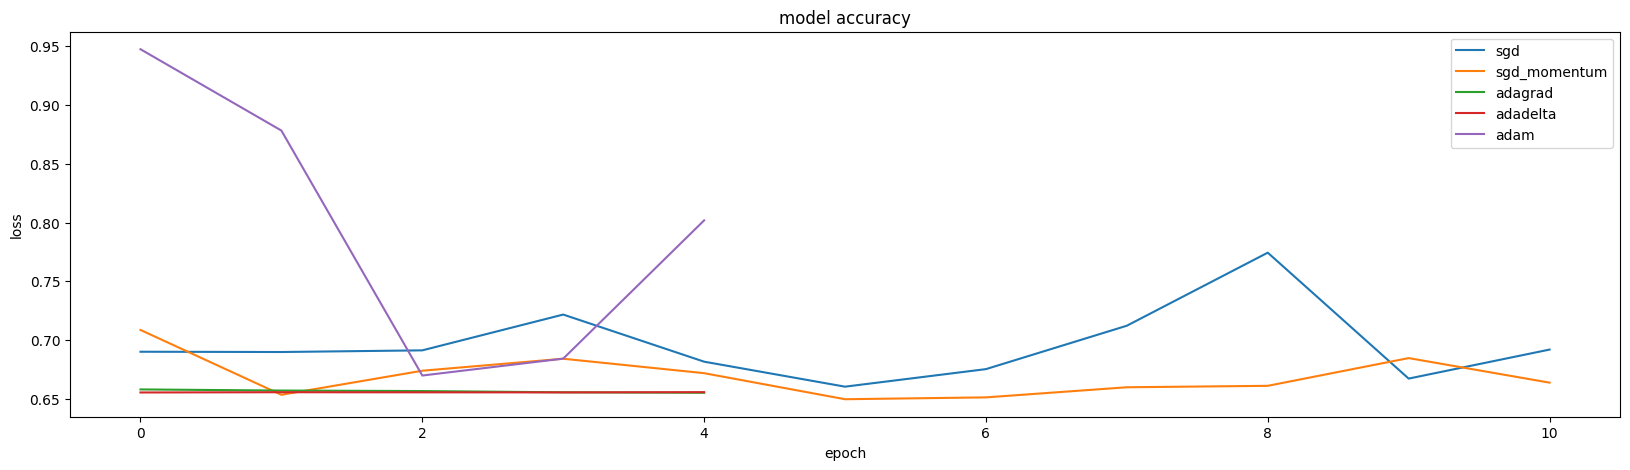

<Figure size 640x480 with 0 Axes>

In [15]:
plt.figure(figsize=(20,5))
for optimizer in optimizers_list:
    multi_disease_model.compile(optimizer = optimizer[1], loss = 'binary_crossentropy',
                           metrics = ['binary_accuracy', 'mae'])
    
    history = multi_disease_model.fit(train_gen, 
                                  steps_per_epoch=1000,
                                  validation_data = (test_X, test_Y), 
                                  epochs = 50, 
                                  callbacks = callbacks_list)
      
    
    plt.plot(history.history['val_loss'])
    
plt.legend([x[0] for x in optimizers_list], loc='upper right')
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()
plt.savefig('optimizer_selection.png', bbox_inches='tight')

#  VGG19

In [16]:
class VGG19(nn.Module):
    def __init__(self, num_classes=2):
        super(VGG19, self).__init__()
        self.features = self._make_layers([
            64, 64, 'M', 
            128, 128, 'M', 
            256, 256, 256, 256, 'M', 
            512, 512, 512, 512, 'M', 
            512, 512, 512, 512, 'M'
        ])
        self.classifier = nn.Sequential(
            nn.Linear(8192, 4096),  # Adjusted to match the actual size
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def _make_layers(self, cfg):
        layers = []
        in_channels = 1  # Change to 3 if your images are RGB
        for v in cfg:
            if v == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
                layers += [conv2d, nn.ReLU(inplace=True)]
                in_channels = v
        return nn.Sequential(*layers)

# Initialize the model, loss function, and optimizer
model = VGG19(num_classes=2)  # For binary classification
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Assuming 'train_loader' and 'test_loader' are defined as in your simple CNN example

# Training Loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}')

    # Validation Loop
    model.eval()
    total = 0
    correct = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'Accuracy on validation set: {100 * correct / total}%')

TypeError: cross_entropy_loss(): argument 'target' (position 2) must be Tensor, not tuple